# XY - Modell

In [1]:
# Standard imports for computational physics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import json
from scipy.optimize import curve_fit
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (20, 6)

# Select most recent run

In [2]:
con = sqlite3.connect('output.sqlite')
current_run = pd.read_sql_query('SELECT id FROM runs ORDER BY created_at DESC', con).at[0, 'id']

# Energy

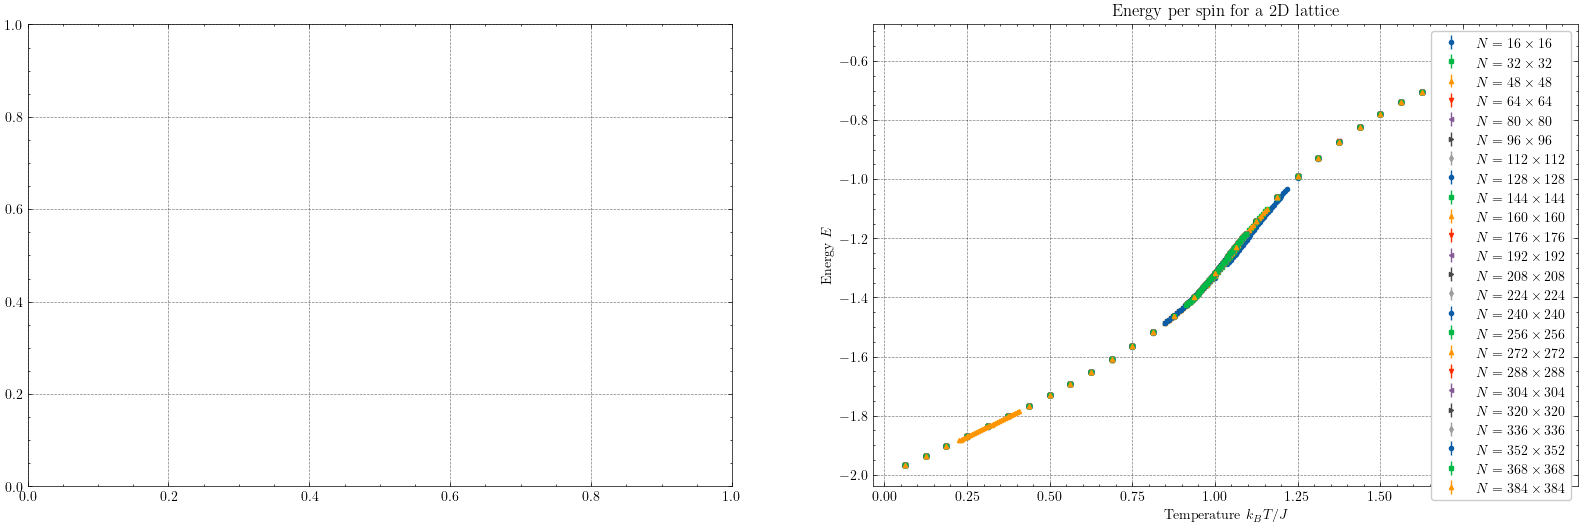

In [3]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['energy'], yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Energy per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Energy $E$')

    ax[name - 1].legend()

fig.savefig('figures/Energy.pdf', bbox_inches='tight')

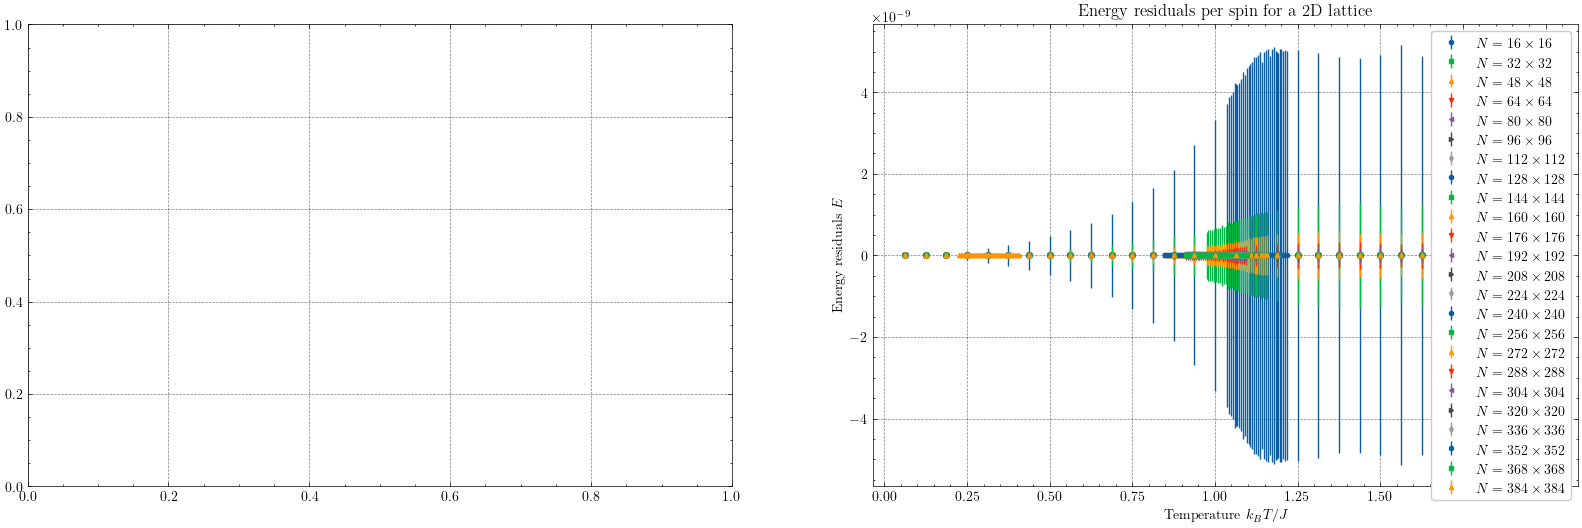

In [5]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], [0] * len(data['energy_std']), yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Energy residuals per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Energy residuals $E$')

    ax[name - 1].legend()

fig.savefig('figures/Energy_Residual.pdf', bbox_inches='tight')

# Magnetisation

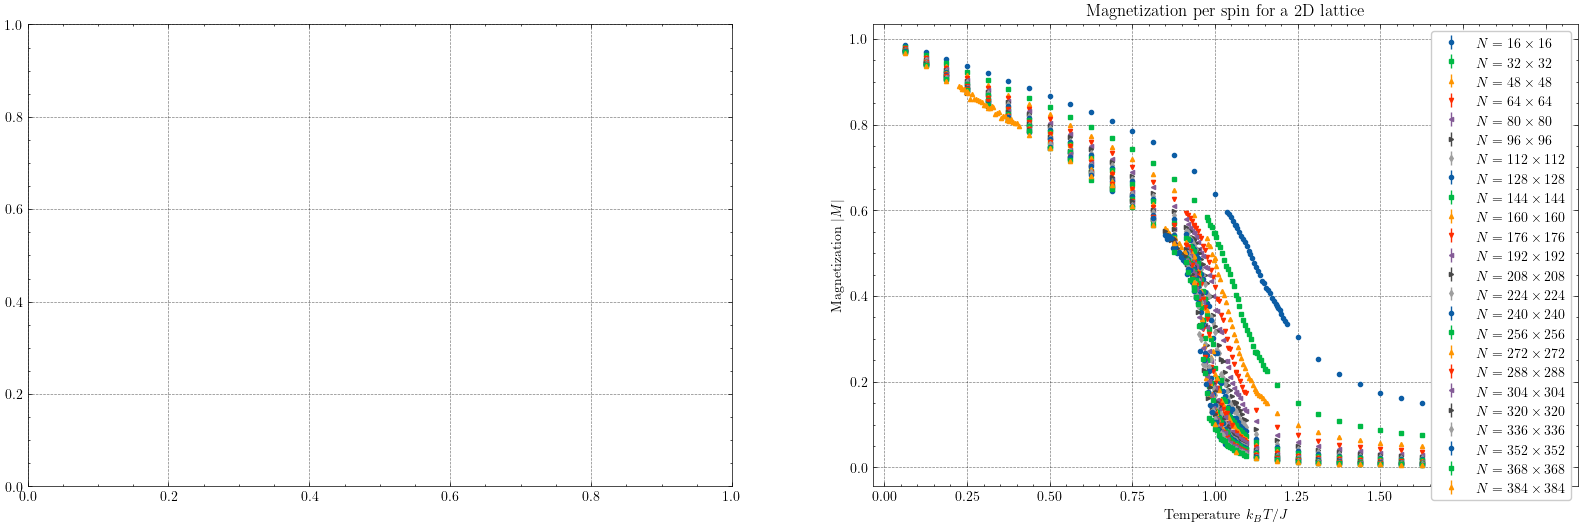

In [6]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['magnet'], yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Magnetization per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Magnetization $\\lvert M \\rvert$')

    ax[name - 1].legend()

fig.savefig('figures/Magnetization.pdf', bbox_inches='tight')

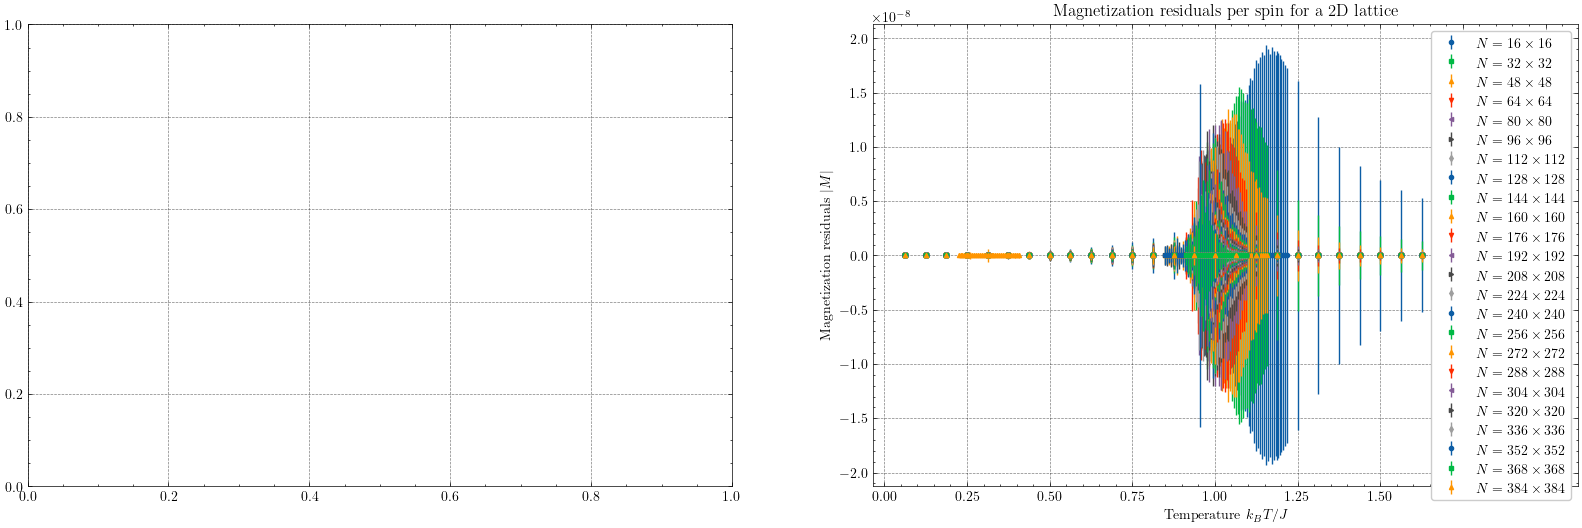

In [7]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], [0] * len(data['magnet_std']), yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Magnetization residuals per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Magnetization residuals $\\lvert M \\rvert$')

    ax[name - 1].legend()

fig.savefig('figures/Magnetization_Residuals.pdf', bbox_inches='tight')

# Specific Heat

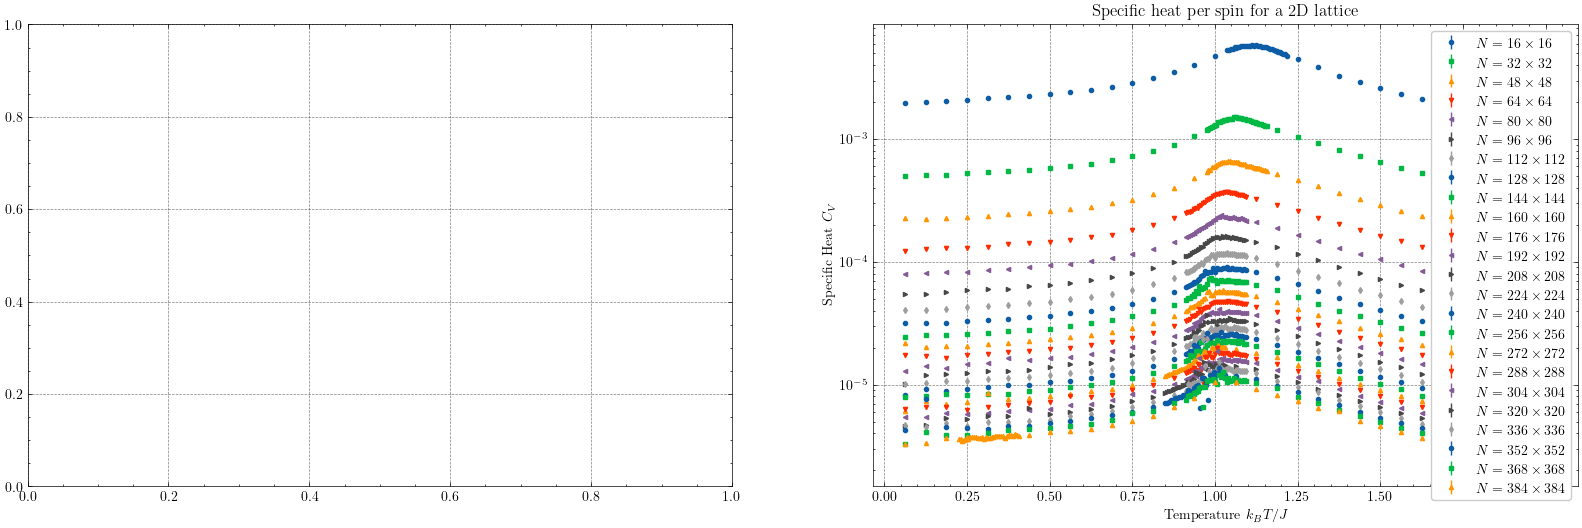

In [7]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, specific_heat, specific_heat_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['specific_heat'], yerr=data['specific_heat_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Specific heat per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Specific Heat $C_V$')

    ax[name - 1].set_yscale('log')
    ax[name - 1].legend()

fig.savefig('figures/Specific_Heat.pdf', bbox_inches='tight')

# Magnetic susceptibility

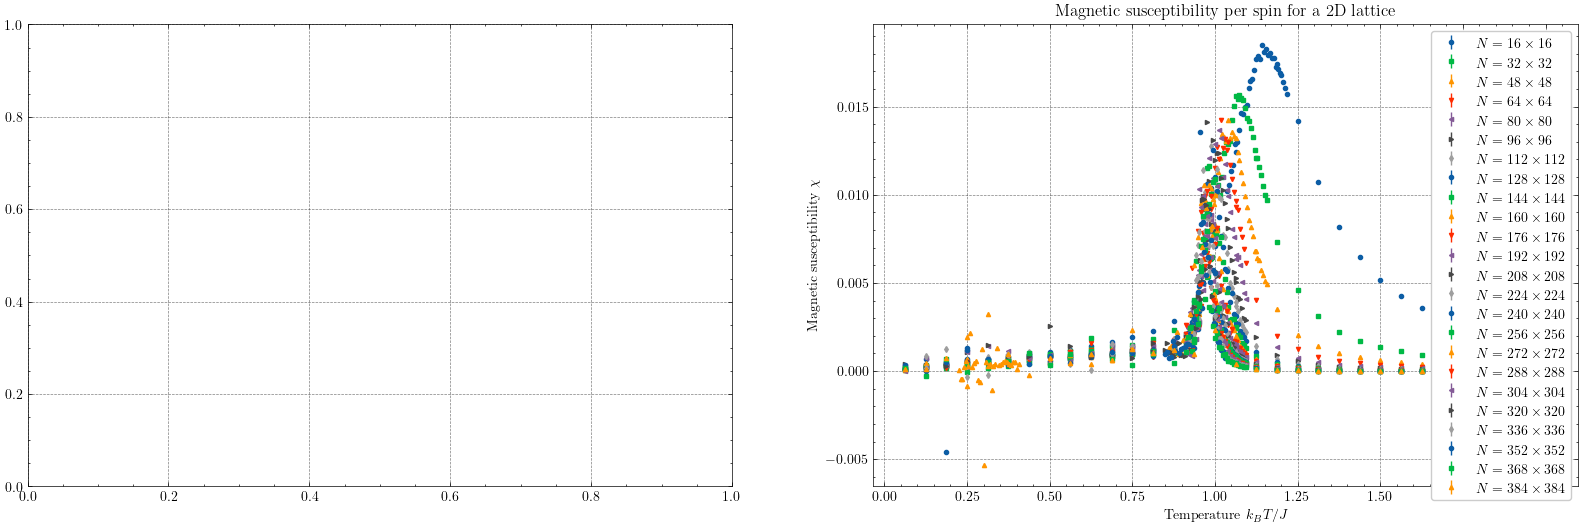

In [6]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, magnet_suscept, magnet_suscept_std FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['magnet_suscept'], yerr=data['magnet_suscept_std'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Magnetic susceptibility per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Magnetic susceptibility $\\chi$')

    #ax[name - 1].set_yscale('log')
    ax[name - 1].legend()

fig.savefig('figures/Magnetic_Susceptibility.pdf', bbox_inches='tight')

,size,temperature,delta
0,0.083255,1.053711,0.002930
1,0.066728,1.015625,0.002930
2,0.057816,1.034180,0.002930
3,0.052077,1.002930,0.002930
4,0.048000,0.970703,0.001953
5,0.044915,1.005859,0.002930


R Squared: 0.63684672


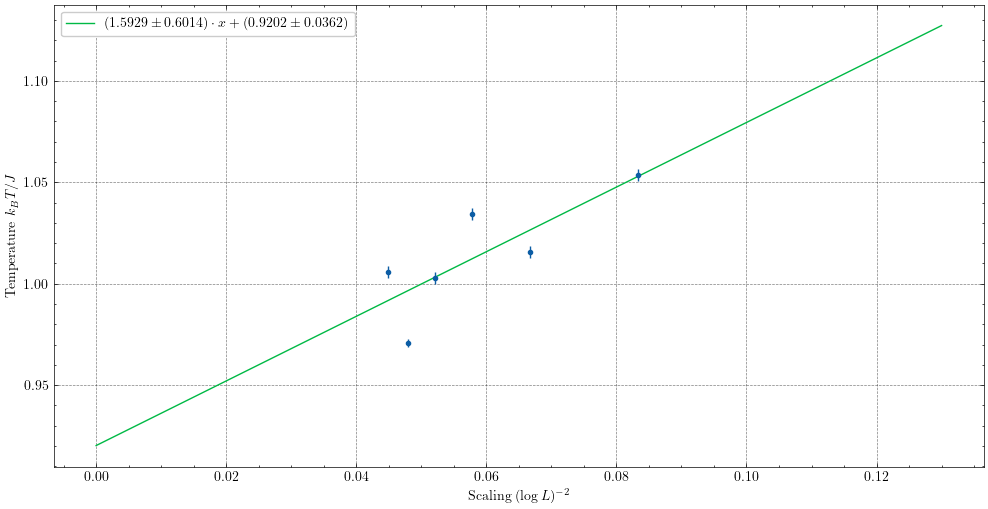

In [52]:
def linear_fn(x: float, slope: float, intercept: float) -> float:
    return slope * x + intercept

data = pd.read_sql_query(f'''SELECT 1.0 / POWER(LN(r.size), 2) AS size, r.temperature, o.delta AS delta
                             FROM (SELECT id, size, temperature, MAX(magnet_suscept) FROM results WHERE dimension = 2 AND run_id = 1 AND size >=32 AND size <= 272 GROUP by size) AS r
                             INNER JOIN (SELECT id, ABS(temperature - LAG(temperature) OVER (PARTITION BY run_id, dimension, size ORDER BY temperature)) AS delta FROM results) AS o ON r.id = o.id''', con)
display(data)


fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(data['size'], data['temperature'], yerr=data['delta'])

popt, pcov = curve_fit(linear_fn, data['size'], data['temperature'])
perr = np.sqrt(np.diag(pcov))

residuals = data['temperature'] - linear_fn(data['size'], *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((data['temperature'] - np.mean(data['temperature']))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R Squared: {r_squared:.8f}')

sampling = np.linspace(0, 0.13, num=100)
ax.plot(sampling, linear_fn(sampling, *popt), '-', label=f'$({popt[0]:.4f} \\pm {perr[0]:.4f}) \\cdot x + ({popt[1]:.4f} \\pm {perr[1]:.4f})$')

ax.set_xlabel('Scaling $(\\log{L})^{-2}$')
ax.set_ylabel('Temperature $k_B T / J$')

ax.legend()
fig.savefig('figures/Critical_Temperature.pdf', bbox_inches='tight')

# Critical Slowing Down

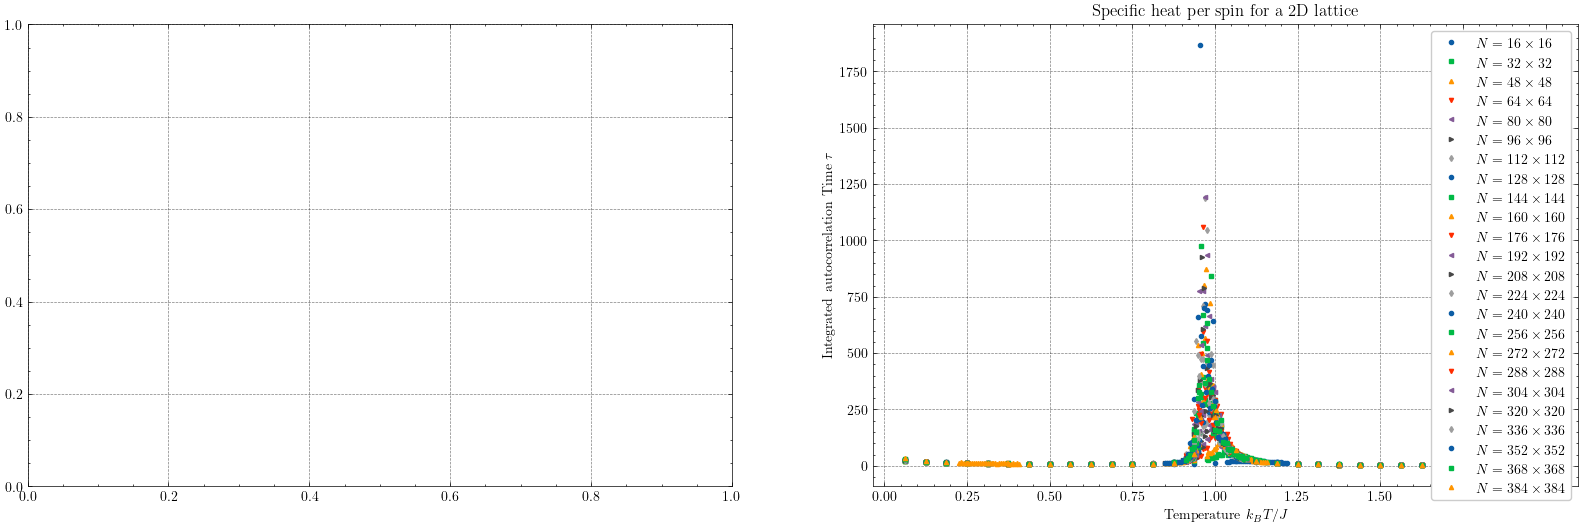

In [26]:
fig, ax = plt.subplots(1, 2)
for name, group in pd.read_sql_query(f'SELECT dimension, size FROM results WHERE run_id = \'{current_run}\' GROUP BY dimension, size ORDER BY dimension', con).groupby('dimension'):
    for size in group['size']:
        data = pd.read_sql_query(f'SELECT temperature, energy_tau FROM results WHERE dimension = \'{name}\' AND run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
        ax[name - 1].errorbar(data['temperature'], data['energy_tau'], label=f'$N = {size} \\times {size}$')

    ax[name - 1].set_title(f'Specific heat per spin for a {name}D lattice')
    ax[name - 1].set_xlabel('Temperature $k_B T / J$')
    ax[name - 1].set_ylabel('Integrated autocorrelation Time $\\tau$')

    ax[name - 1].legend()

fig.savefig('figures/Critical_Slowing_Down.pdf', bbox_inches='tight')

# Scaling

,size,dimension,mc,boot
0,16,2,0.251550,61.150188
1,32,2,1.008200,61.059534
2,48,2,2.277383,61.486491
3,64,2,3.872550,61.595987
4,80,2,6.085083,62.153739
5,96,2,9.239600,62.285778
6,112,2,12.451683,61.770585
7,128,2,15.969583,61.126919
8,144,2,19.949267,62.730156
9,160,2,25.869850,62.977554


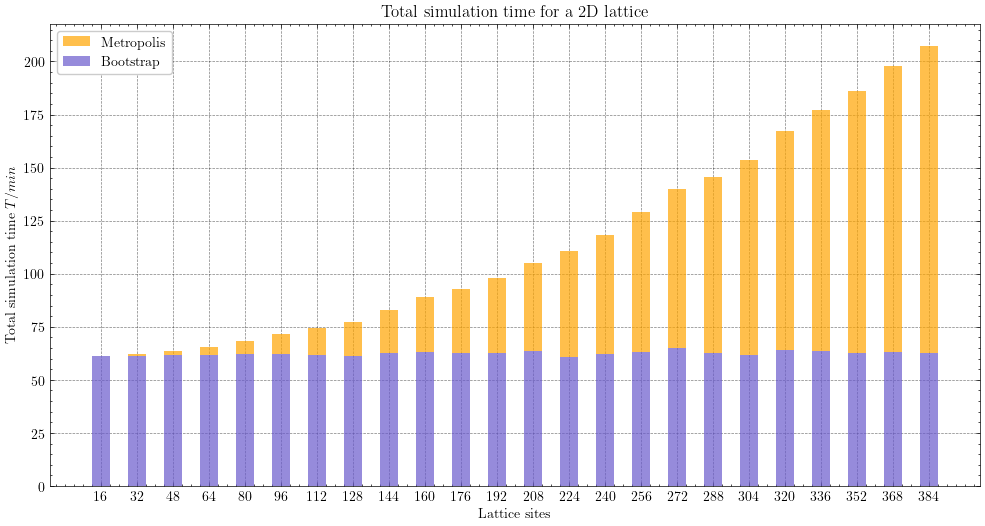

In [4]:
data = pd.read_sql_query(f'SELECT size, dimension, MAX(time_mc) / (60.0 * 1000) AS mc, SUM(time_boot) / (32.0 * 60 * 1000) AS boot FROM results WHERE dimension = 2 AND run_id = \'{current_run}\' GROUP BY size', con)
display(data)

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(data['size'], data['mc'], width=8, alpha=0.7, color='orange', label='Metropolis', bottom=data['boot'])
ax.bar(data['size'], data['boot'], width=8, alpha=0.7, color='slateblue', label='Bootstrap')

ax.set_title(f'Total simulation time for a 2D lattice')
ax.set_xlabel('Lattice sites')
ax.set_ylabel('Total simulation time $T / min$')
ax.set_xticks(data['size'], labels=data['size'])

ax.legend()

fig.savefig('figures/Time_Scaling.pdf', bbox_inches='tight')

# Scheduling

Text(0, 0.5, 'Node name and process ID')

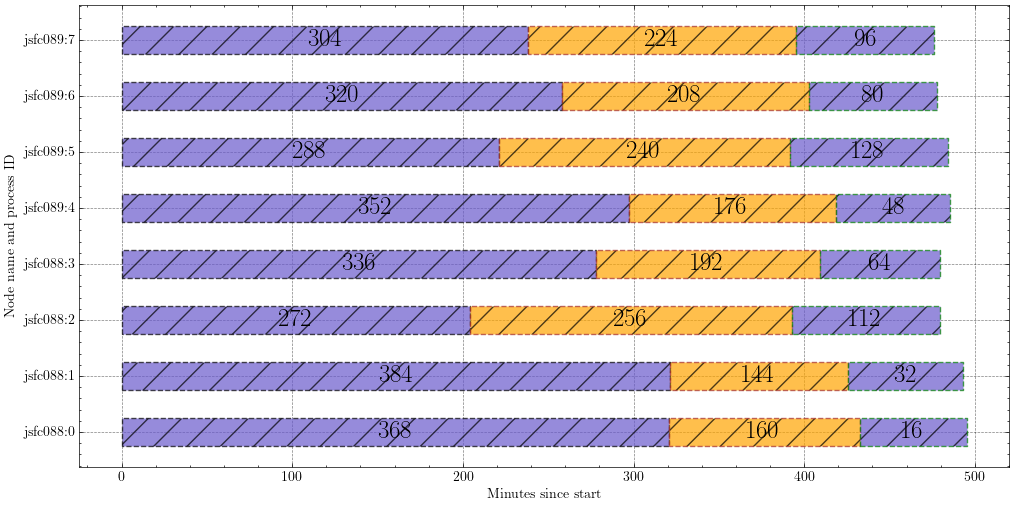

In [5]:
data = pd.read_sql_query(f'SELECT a.size, a.node, CAST(a.process AS TEXT) AS process, a.allocated_at / 60.0 AS allocated_at, (a.finished_at - a.allocated_at) / 60.0 AS duration FROM allocations AS a INNER JOIN results AS r ON r.run_id = a.run_id AND r.dimension = a.dimension AND r.size = a.size WHERE a.run_id = \'{current_run}\' AND a.dimension = 2 GROUP BY a.size, a.node, a.process, a.allocated_at ORDER BY a.node, a.process, allocated_at ASC', con)

min = data['allocated_at'].min()
data['allocated_at'] = data['allocated_at'].transform(lambda x: x - min)

fig, ax = plt.subplots(figsize=(12, 6))
for idx, (node, group) in enumerate(data.groupby(['node', 'process'])):
    allocations = list(group[['allocated_at', 'duration']].itertuples(index=False, name=None))
    ax.broken_barh(allocations, (idx * 1 - 0.25, 0.5), linewidth=1, color=['slateblue', 'orange'], alpha=0.7, edgecolor=['black', 'brown', 'green', 'blue'], linestyle='dashed', hatch='/')

    sizes = list(group[['size', 'allocated_at', 'duration']].itertuples(index=False, name=None))
    for size, x1, x2 in sizes:
        ax.text(x=x1 + x2/2, y=idx, s=size, ha='center', va='center', fontsize=18, weight='bold')

labels = list(map(lambda x: f'{x[0]}:{x[1]}', data[['node', 'process']].itertuples(index=False, name=None)))
ax.set_yticks(range(len(np.unique(labels))), labels=np.unique(labels))
ax.set_xlabel('Minutes since start')
ax.set_ylabel('Node name and process ID')